**Data Preprocessing**

In [193]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train:', x_train.shape)

K = len(np.unique(y_train)) # Classes
Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = 3072 # CIFAR10

mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train: (50000, 32, 32, 3)
w1: (3072, 10)
b1: (10,)


**Question 02**

In [293]:
class NeuralNetwork():
    '''
    A two layer neural network
    '''
        
    def __init__(self, layers=[3072,200,10], learning_rate=0.01, iterations=300):
        self.params = {}
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.train_loss_history = []
        self.valid_loss_history = []
        self.train_acc_history = []
        self.valid_acc_history = []
        self.sample_size = None
        self.layers = layers
        self.X = None
        self.y = None
                
    def init_weights(self):
        '''
        Initialize the weights from a random normal distribution
        '''
        np.random.seed(1) # Seed the random number generator
        std=1e-5
        self.params["W1"] = std*np.random.randn(self.layers[0], self.layers[1]) 
        self.params['b1'] = np.zeros(self.layers[1])
        self.params['W2'] = std*np.random.randn(self.layers[1],self.layers[2]) 
        self.params['b2'] = np.zeros(self.layers[2])

    def dSigmoid(self, Z):
        S = 1/(1+np.exp(-Z))
        return S*(1-S)

    def sigmoid(self,Z):
        '''
        The sigmoid function takes in real numbers in any range and 
        squashes it to a real-valued output between 0 and 1.
        '''
        return 1/(1+np.exp(-Z))

    def MSE(self,y,yhat):
        reg = 5e-5
        loss = 1/(2*len(y))*np.square(yhat - y).sum() + reg/(y.shape[0]*2)*(np.sum(self.params['W1']*self.params['W1'])+np.sum(self.params['W2']*self.params['W2']))
        return loss

    def forward_propagation(self):
        '''
        Performs the forward propagation
        '''
        
        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        A1 = self.sigmoid(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        yhat = Z2
        loss = self.MSE(self.y,yhat)

        # save calculated parameters     
        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['A1'] = A1

        return yhat,loss

    def back_propagation(self,yhat):
        '''
        Computes the derivatives and update weights and bias according.
        '''
        reg = 5e-5
        y_inv = 1 - self.y
        yhat_inv = 1 - yhat

        dl_wrt_yhat = (1/len(yhat))*(yhat - self.y)

        dl_wrt_A1 = dl_wrt_yhat.dot(self.params['W2'].T)
        dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_yhat) + 1./yhat.shape[0]*reg*self.params['W2']
        dl_wrt_b2 = np.sum(dl_wrt_yhat, axis=0, keepdims=True)

        dl_wrt_z1 = dl_wrt_A1 * self.dSigmoid(self.params['Z1'])
        dl_wrt_w1 = self.X.T.dot(dl_wrt_z1) + 1./yhat.shape[0]*reg*self.params['W1']
        dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0, keepdims=True)

        #update the weights and bias
        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2

    def fit(self, X, y):
        '''
        Trains the neural network using the specified data and labels
        '''
        lr_decay = 0.99
        train_data = X[0:round(X.shape[0]*0.9),:]
        train_lbl = y[0:round(X.shape[0]*0.9),:]
        valid_data = X[round(X.shape[0]*0.9):,:]
        valid_lbl = y[round(X.shape[0]*0.9):,:]
        self.X = train_data 
        self.y = train_lbl
        self.init_weights() #initialize weights and bias


        for i in range(self.iterations):
            yhat, loss = self.forward_propagation()
            self.back_propagation(yhat)
            train_acc = self.acc(self.y,yhat)
            self.train_acc_history.append(train_acc)
            valid_pred = self.predict(valid_data)
            valid_loss = self.MSE(valid_lbl,valid_pred)
            self.valid_loss_history.append(valid_loss)
            valid_acc = self.acc(valid_lbl,valid_pred) 
            self.valid_acc_history.append(valid_acc)
            self.train_loss_history.append(loss)
            self.learning_rate *= lr_decay
            print('Epoch %d/%d: Train Loss: %f, Training Accuracy: %f, Validation Loss: %f, Validation Accuracy: %f'%(i+1, self.iterations,loss, train_acc, valid_loss, valid_acc))
            

    def predict(self, X):
        '''
        Predicts on a test data
        '''
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.sigmoid(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        pred = Z2
        return pred 

    def acc(self, y, yhat):
        '''
        Calculates the accutacy between the predicted valuea and the truth labels
        '''
        acc = np.sum(np.argmax(yhat, axis=1) == np.argmax(y, axis=1))/(y.shape[0])
        return acc


    def learningCurves(self):
        '''
        Plots the loss curve
        '''
        fig, axes = plt.subplots(1, 4, figsize = (20,5))

        axes[0].plot(self.train_acc_history)
        axes[1].plot(self.valid_acc_history)
        axes[2].plot(self.train_loss_history)
        axes[3].plot(self.valid_loss_history)
        axes[0].set(xlabel='Iterations', ylabel='Train Accuracy')
        axes[1].set(xlabel='Iterations', ylabel='Validation Accuracy')
        axes[2].set(xlabel='Iterations', ylabel='Train Loss')
        axes[3].set(xlabel='Iterations', ylabel='Validation Loss')
        plt.show()  


In [285]:
nn = NeuralNetwork() # create the NN model
nn.fit(x_train, y_train) #train the model

Epoch 1/300: Train Loss: 0.499969, Training Accuracy: 0.099289, Validation Loss: 0.462005, Validation Accuracy: 0.095000
Epoch 2/300: Train Loss: 0.461995, Training Accuracy: 0.100556, Validation Loss: 0.452891, Validation Accuracy: 0.095000
Epoch 3/300: Train Loss: 0.452874, Training Accuracy: 0.100556, Validation Loss: 0.450697, Validation Accuracy: 0.095000
Epoch 4/300: Train Loss: 0.450678, Training Accuracy: 0.100556, Validation Loss: 0.450154, Validation Accuracy: 0.095000
Epoch 5/300: Train Loss: 0.450133, Training Accuracy: 0.100600, Validation Loss: 0.449982, Validation Accuracy: 0.117600
Epoch 6/300: Train Loss: 0.449961, Training Accuracy: 0.121289, Validation Loss: 0.449842, Validation Accuracy: 0.149200
Epoch 7/300: Train Loss: 0.449823, Training Accuracy: 0.152644, Validation Loss: 0.449634, Validation Accuracy: 0.153800
Epoch 8/300: Train Loss: 0.449615, Training Accuracy: 0.158933, Validation Loss: 0.449558, Validation Accuracy: 0.156800
Epoch 9/300: Train Loss: 0.44956

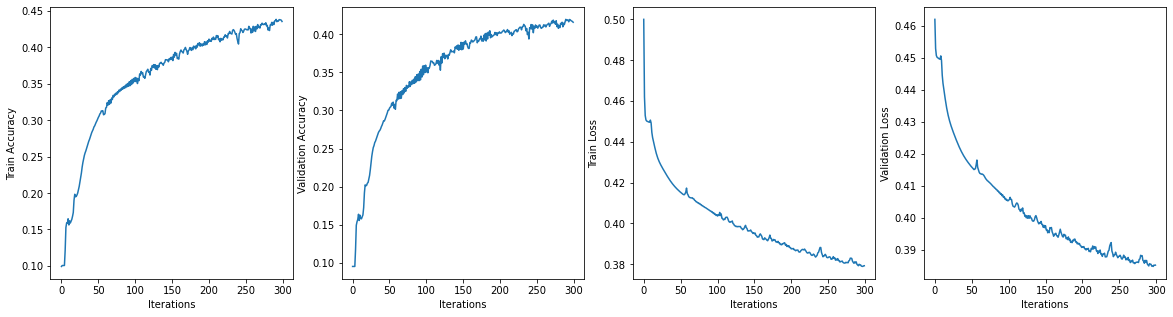

In [286]:
nn.learningCurves()

In [287]:
train_pred = nn.predict(x_train)
test_pred = nn.predict(x_test)

print("Train accuracy : {}".format(nn.acc(y_train, train_pred)))
print("Test accuracy : {}".format(nn.acc(y_test, test_pred)))

Train accuracy : 0.43448
Test accuracy : 0.4224


**Question 03**

In [322]:
class NeuralNetwork():
    '''
    A two layer neural network
    '''
        
    def __init__(self, layers=[3072,200,10], learning_rate=0.01, iterations=50):
        self.params = {}
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.train_loss_history = []
        self.valid_loss_history = []
        self.train_acc_history = []
        self.valid_acc_history = []
        self.sample_size = None
        self.layers = layers
        self.X = None
        self.y = None
                
    def init_weights(self):
        '''
        Initialize the weights from a random normal distribution
        '''
        np.random.seed(1) # Seed the random number generator
        std=1e-5
        self.params["W1"] = std*np.random.randn(self.layers[0], self.layers[1]) 
        self.params['b1'] = np.zeros(self.layers[1])
        self.params['W2'] = std*np.random.randn(self.layers[1],self.layers[2]) 
        self.params['b2'] = np.zeros(self.layers[2])

    def dSigmoid(self, Z):
        S = 1/(1+np.exp(-Z))
        return S*(1-S)

    def sigmoid(self,Z):
        '''
        The sigmoid function takes in real numbers in any range and 
        squashes it to a real-valued output between 0 and 1.
        '''
        return 1/(1+np.exp(-Z))

    def MSE(self,y,yhat):
        reg = 1e-1
        loss = 1/(2*len(y))*np.square(yhat - y).sum() + reg/(y.shape[0]*2)*(np.sum(self.params['W1']*self.params['W1'])+np.sum(self.params['W2']*self.params['W2']))
        return loss

    def forward_propagation(self):
        '''
        Performs the forward propagation
        '''
        
        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        A1 = self.sigmoid(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        yhat = Z2
        loss = self.MSE(self.y,yhat)

        # save calculated parameters     
        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['A1'] = A1

        return yhat,loss

    def back_propagation(self,yhat):
        '''
        Computes the derivatives and update weights and bias according.
        '''
        reg = 1e-1
        y_inv = 1 - self.y
        yhat_inv = 1 - yhat

        dl_wrt_yhat = (1/len(yhat))*(yhat - self.y)

        dl_wrt_A1 = dl_wrt_yhat.dot(self.params['W2'].T)
        dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_yhat) + 1./yhat.shape[0]*reg*self.params['W2']
        dl_wrt_b2 = np.sum(dl_wrt_yhat, axis=0, keepdims=True)

        dl_wrt_z1 = dl_wrt_A1 * self.dSigmoid(self.params['Z1'])
        dl_wrt_w1 = self.X.T.dot(dl_wrt_z1) + 1./yhat.shape[0]*reg*self.params['W1']
        dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0, keepdims=True)

        #update the weights and bias
        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2

    def fit(self, X, y):
        '''
        Trains the neural network using the specified data and labels
        '''
        lr_decay = 0.99
        batch_size = 500
        train_data = X[0:round(X.shape[0]*0.9),:]
        train_lbl = y[0:round(X.shape[0]*0.9),:]
        valid_data = X[round(X.shape[0]*0.9):,:]
        valid_lbl = y[round(X.shape[0]*0.9):,:]

        self.init_weights() #initialize weights and bias
        steps = round(train_data.shape[0]/500)

        for i in range(self.iterations):
          for j in range(steps):
            self.X = train_data[j*500:(j+1)*500,:]
            self.y = train_lbl[j*500:(j+1)*500,:]

            yhat, loss = self.forward_propagation()
            self.back_propagation(yhat)

          train_acc = self.acc(self.y,yhat)
          valid_pred = self.predict(valid_data)
          valid_loss = self.MSE(valid_lbl,valid_pred)
          self.valid_loss_history.append(valid_loss)
          valid_acc = self.acc(valid_lbl,valid_pred) 
          self.valid_loss_history.append(valid_loss)
          self.train_acc_history.append(train_acc)
          self.valid_acc_history.append(valid_acc)
          self.train_loss_history.append(loss)
          self.learning_rate *= lr_decay
          print('Epoch %d/%d: Train Loss: %f, Training Accuracy: %f, Validation Loss: %f, Validation Accuracy: %f'%(i+1, self.iterations,loss, train_acc, valid_loss, valid_acc))


    def predict(self, X):
        '''
        Predicts on a test data
        '''
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.sigmoid(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        pred = Z2
        return pred 

    def acc(self, y, yhat):
        '''
        Calculates the accutacy between the predicted valuea and the truth labels
        '''
        acc = np.sum(np.argmax(yhat, axis=1) == np.argmax(y, axis=1))/(y.shape[0])
        return acc


    def learningCurves(self):
        '''
        Plots the llearning curves
        '''
        fig, axes = plt.subplots(1, 4, figsize = (20,5))

        axes[0].plot(self.train_acc_history)
        axes[1].plot(self.valid_acc_history)
        axes[2].plot(self.train_loss_history)
        axes[3].plot(self.valid_loss_history)
        axes[0].set(xlabel='Iterations', ylabel='Train Accuracy')
        axes[1].set(xlabel='Iterations', ylabel='Validation Accuracy')
        axes[2].set(xlabel='Iterations', ylabel='Train Loss')
        axes[3].set(xlabel='Iterations', ylabel='Validation Loss')
        plt.show()  

In [323]:
nn = NeuralNetwork() # create the NN model
nn.fit(x_train, y_train) #train the model

Epoch 1/50: Train Loss: 0.407905, Training Accuracy: 0.336000, Validation Loss: 0.410066, Validation Accuracy: 0.324400
Epoch 2/50: Train Loss: 0.396064, Training Accuracy: 0.362000, Validation Loss: 0.397458, Validation Accuracy: 0.372800
Epoch 3/50: Train Loss: 0.392362, Training Accuracy: 0.350000, Validation Loss: 0.394615, Validation Accuracy: 0.388600
Epoch 4/50: Train Loss: 0.384706, Training Accuracy: 0.392000, Validation Loss: 0.387583, Validation Accuracy: 0.414400
Epoch 5/50: Train Loss: 0.380363, Training Accuracy: 0.414000, Validation Loss: 0.384498, Validation Accuracy: 0.424200
Epoch 6/50: Train Loss: 0.377716, Training Accuracy: 0.418000, Validation Loss: 0.384296, Validation Accuracy: 0.424400
Epoch 7/50: Train Loss: 0.373601, Training Accuracy: 0.432000, Validation Loss: 0.381014, Validation Accuracy: 0.430400
Epoch 8/50: Train Loss: 0.370638, Training Accuracy: 0.450000, Validation Loss: 0.380095, Validation Accuracy: 0.430800
Epoch 9/50: Train Loss: 0.365767, Traini

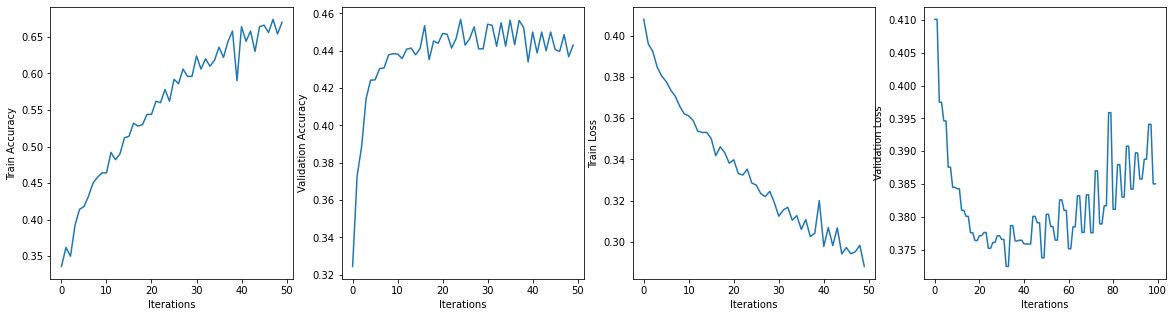

In [325]:
nn.learningCurves()

In [326]:
train_pred = nn.predict(x_train)
test_pred = nn.predict(x_test)

print("Train accuracy : {}".format(nn.acc(y_train, train_pred)))
print("Test accuracy : {}".format(nn.acc(y_test, test_pred)))

Train accuracy : 0.63886
Test accuracy : 0.4433
